In [6]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [7]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Scenario 2
Gains moyen faibles avec 10 bras

### Paramètres du scenario

In [8]:
#Paramètres du scenario 2
p = np.array([0.05, 0.02, 0.01, 0.05, 0.02, 0.01, 0.05, 0.02, 0.01, 0.1]) #Paramètres des Bernoulli
K= p.shape[0] #Nombre de bras
delta= ( np.ones(K)*np.max(p) ) - p

T= 50000 #Nombre de périodes
runs = 10 #Nombre d'itérations

print("Pi:",p)
print("delta:",delta)

Pi: [ 0.05  0.02  0.01  0.05  0.02  0.01  0.05  0.02  0.01  0.1 ]
delta: [ 0.05  0.08  0.09  0.05  0.08  0.09  0.05  0.08  0.09  0.  ]


## UCB
On prend $\alpha = 3$

In [9]:
alpha = 3
actions_list_ucb3 = []
total_rewards_list_ucb3 = np.zeros((runs,T))
start_time = time.time()

for run in range(runs):    
    #ucb Params Iinitialization
    N = np.zeros(K) #Nb de fois ou le bras 1 ou 2 a été tiré
    rewards = np.zeros((K, T), dtype=np.int) #Recompense avec chaque bras
    actions = np.zeros((K, T), dtype=np.int) #Bras choisi à chaque étape
    ucb = np.zeros(K) #ucb pour chaque bras

    #On commence en explorant les 2 bras au moins une fois
    # 0 < t < K 
    for t in range(K):
        N[t]=1
        rewards[t,t]= np.random.binomial(1, p[t])
        actions[t,t]=1

    #t >= K
    for t in range(K, T):
        for k in range(K):
            ucb[k] = np.sum(rewards[k,:t])/N[k]+np.sqrt((alpha*math.log(t))/(2*N[k]))

        select = np.argmax(ucb)
        N[select] += 1
        actions[select,t] = 1
        rewards[select,t] = np.random.binomial(1,p[select])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Reward accumulé pour chaque bras en fonction du temps
    total_rewards = np.sum(cumulative_rewards, axis=0) #Reward sur tout les bras accumulé en fonction du temps
    total_rewards_list_ucb3[run,:] = np.copy(total_rewards)
    actions_list_ucb3.append(np.copy(actions))

time_spent_ucb3 = time.time() - start_time
print("Time for UCB, with alpha = 3 and T =", T, ", runs =", runs, ":", time_spent_ucb3, "seconds")

Time for UCB, with alpha = 3 and T = 50000 , runs = 10 : 507.4306433200836 seconds


## KL-UCB
On utilise seulement la méthode de dichotomie

In [10]:
%%capture
klucb_dichotomie = kl_ucb_policy.KLUCBPolicy(K, kl_ucb_policy.klucb_upper_bisection)

total_rewards_list_klucb_dichotomie = np.zeros((runs,T))
actions_list_klucb_dichotomie = []
start_time = time.time()

for run in range(runs):
    klucb_dichotomie.reset()
    actions = np.zeros((K, T), dtype=np.int)
    rewards = np.zeros((K, T), dtype=np.int)

    for t in range(T):
        arm = klucb_dichotomie.select_next_arm()
        actions[arm, t] = 1
        rewards[arm, t] = np.random.binomial(1, p[arm])
        klucb_dichotomie.update_state(arm, rewards[arm, t])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Reward accumulé pour chaque bras en fonction du temps
    total_rewards = np.sum(cumulative_rewards, axis=0) #Reward sur tout les bras accumulé en fonction du temps
    total_rewards_list_klucb_dichotomie[run,:] = np.copy(total_rewards)
    actions_list_klucb_dichotomie.append(np.copy(actions))

time_spent_klucb_dichotomie = time.time() - start_time

In [12]:
print("Time for KL-UCB (Newton), with T =", T, ", runs =", runs, ":", (time_spent_klucb_dichotomie), "seconds")

Time for KL-UCB (Newton), with T = 50000 , runs = 10 : 1622.4962077140808 seconds


## Résultats

## Gain total moyen

In [13]:
mean_total_rewards_list_ucb3 = np.mean(total_rewards_list_ucb3, axis=0)
print("t & Reward (total) UCB :",t, mean_total_rewards_list_ucb3[t] )
mean_total_rewards_list_klucb_dichotomie = np.mean(total_rewards_list_klucb_dichotomie, axis=0)
print("t & Reward (total) KL-UCB :",t, mean_total_rewards_list_klucb_dichotomie[t] )

t & Reward (total) UCB : 49999 3819.4
t & Reward (total) KL-UCB : 49999 4825.4


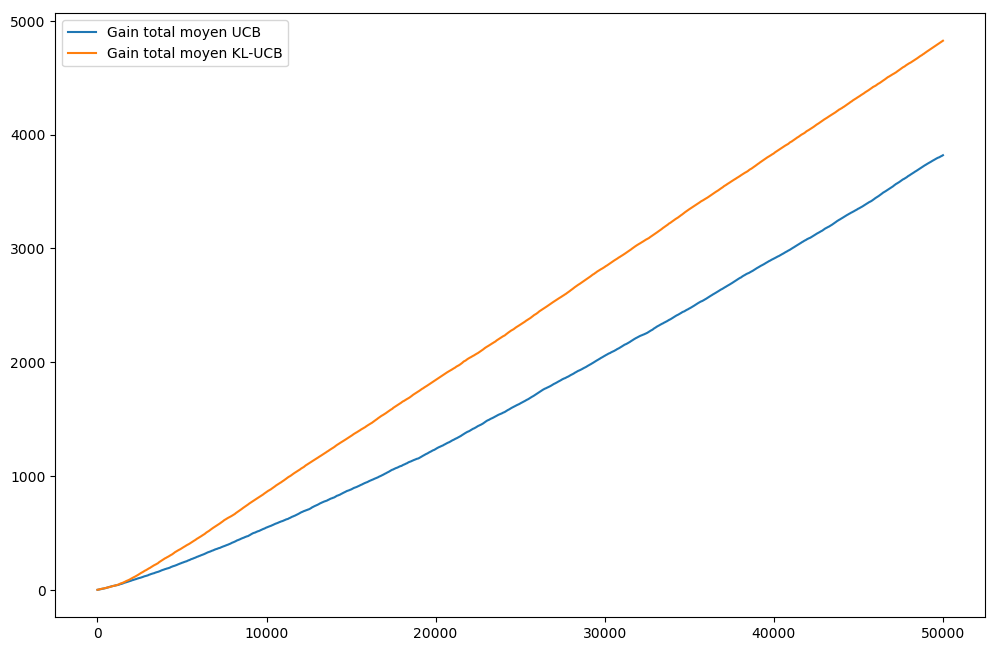

In [14]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(mean_total_rewards_list_ucb3[:],linestyle='-',label='Gain total moyen UCB')
ax1.plot(mean_total_rewards_list_klucb_dichotomie[:],linestyle='-',label='Gain total moyen KL-UCB')
ax1.legend(loc='best')
plt.show()

## Evolution moyenne du Pseudo-Regret en fonction de t

In [16]:
#UCB
total_action_ucb = np.zeros((K,T))
for actions_ucb3 in actions_list_ucb3:
    total_action_ucb += np.cumsum(actions_ucb3, axis=1) #Nb d'actions accumulé sur chaque bras
total_action_ucb = total_action_ucb / runs
regret_cumule_ucb = np.dot(delta, total_action_ucb[:,:]) #Regret accumulé

#KL-UCB
total_action_klucb = np.zeros((K,T))
for actions_klucb in actions_list_klucb_dichotomie:
    total_action_klucb += np.cumsum(actions_klucb, axis=1) #Nb d'actions accumulé sur chaque bras
total_action_klucb = total_action_klucb / runs
regret_cumule_klucb = np.dot(delta, total_action_klucb[:,:]) #Regret accumulé

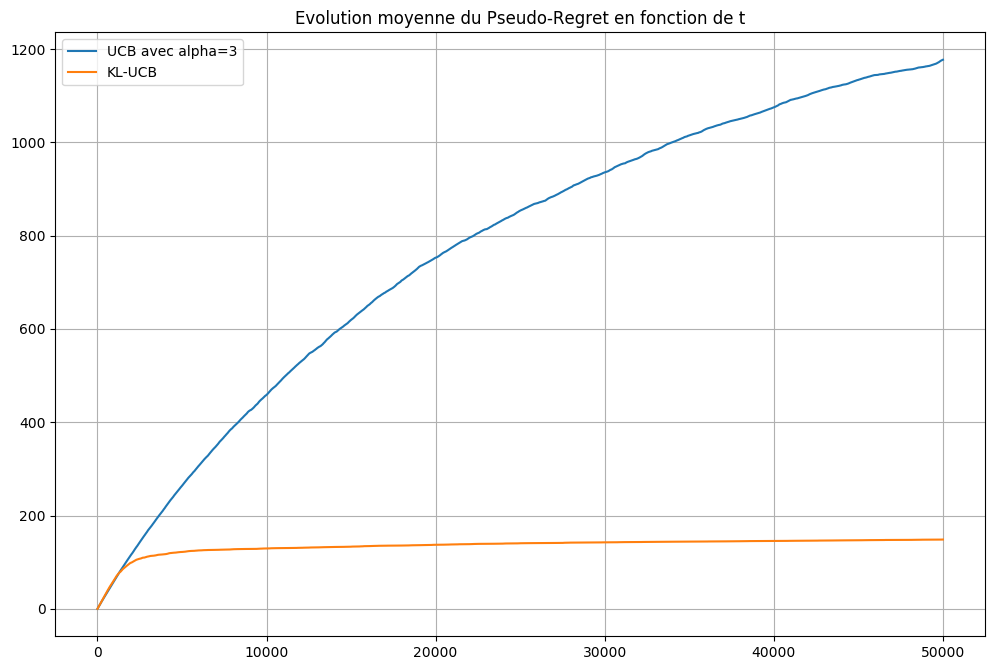

In [17]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(regret_cumule_ucb[:],linestyle='-', label='UCB avec alpha=3')
ax1.plot(regret_cumule_klucb[:],linestyle='-', label='KL-UCB')

ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution moyenne du Pseudo-Regret en fonction de t')
#ax1.xscale('log')
plt.show()

## Distribution du regret

In [18]:
T0 = 4999

In [21]:
#UCB
distribution_regret_ucb = []
for actions_ucb in actions_list_ucb3:
    distribution_regret_ucb.append(np.dot(delta, np.sum(actions_ucb3[:,:T0], axis=1)))

#KL-UCB
distribution_regret_klucb = []
for actions_klucb in actions_list_klucb_dichotomie:
    distribution_regret_klucb.append(np.dot(delta, np.sum(actions_klucb[:,:T0], axis=1)))

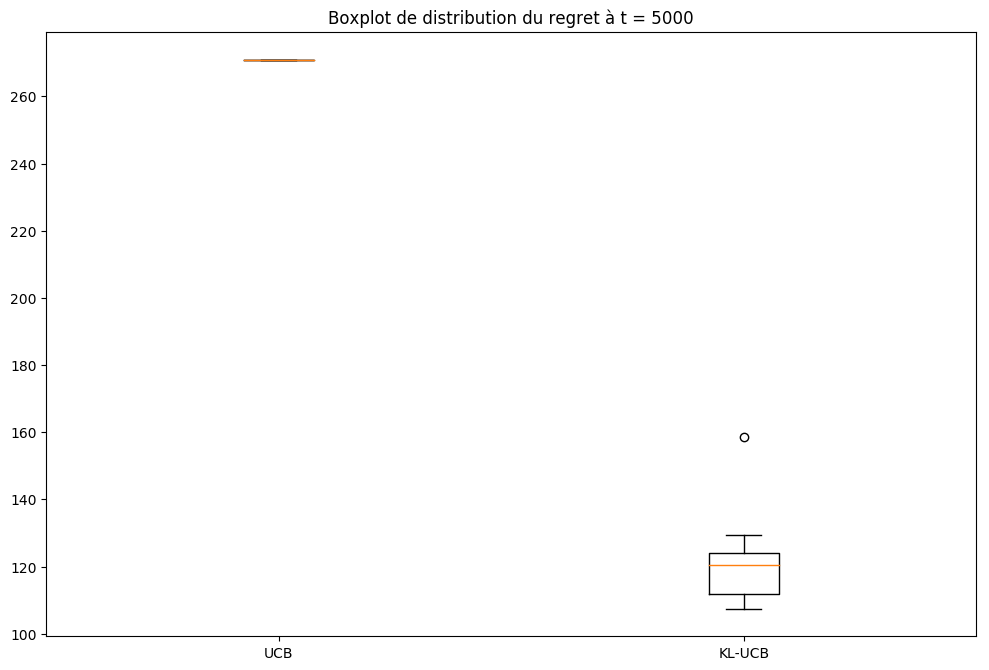

In [23]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.boxplot([
        distribution_regret_ucb, 
        distribution_regret_klucb
    ])
ax.set_xticklabels([
        'UCB', 
        'KL-UCB'
    ])

ax.set_title('Boxplot de distribution du regret à t = 5000')
plt.show()